Load the 2d script

In [1]:
import imp
from astropy.io import fits
import glob, os, sys
twodlvm = imp.load_source('2d_LVM', '2d_projection.py')

Create the spectrograph PSF maps

In [2]:
psf_m=False
if psf_m:
    twodlvm.get_focus(dir1='libs/',name='focus_lvm_blue1',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)
    twodlvm.get_focus(dir1='libs/',name='focus_lvm_red1',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)
    twodlvm.get_focus(dir1='libs/',name='focus_lvm_ir1',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)

    twodlvm.get_focus(dir1='libs/',name='focus_lvm_blue2',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)
    twodlvm.get_focus(dir1='libs/',name='focus_lvm_red2',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)
    twodlvm.get_focus(dir1='libs/',name='focus_lvm_ir2',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)

    twodlvm.get_focus(dir1='libs/',name='focus_lvm_blue3',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)
    twodlvm.get_focus(dir1='libs/',name='focus_lvm_red3',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)
    twodlvm.get_focus(dir1='libs/',name='focus_lvm_ir3',dsx=1.1,dsy=0.8,rho=0.5,vt1=0.1,vt2=0.1,vt3=0.05,lt=1500.)

Read de output files from the LVM_sim

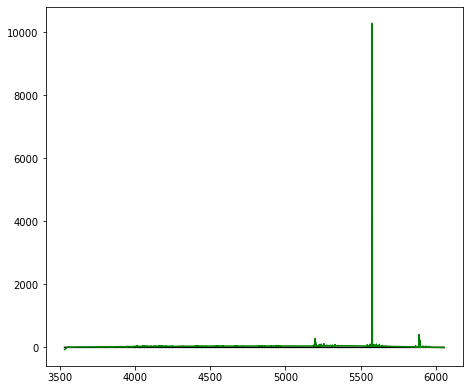

In [3]:
import matplotlib.pyplot as plt
import numpy as np
typ='blue'
base_name='reference'
base_name='LVM_customneb2_example'
base_name='LVM_test'
base_name='LVM_example'
exptime='900'#'21600'

cube_file=base_name+'_'+typ+'_full_'+exptime+'_no_noise.fits'
dir_cube='out_lvm_sim/'

hdr0=fits.getheader(dir_cube+cube_file, 0)
Target,hdr1=fits.getdata(dir_cube+cube_file, 1, header=True)
Total,hdr2=fits.getdata(dir_cube+cube_file, 2, header=True)
Err,hdr3=fits.getdata(dir_cube+cube_file, 3, header=True)
SNR,hdr4=fits.getdata(dir_cube+cube_file, 4, header=True)
Sky,hdr5=fits.getdata(dir_cube+cube_file, 5, header=True)
Wave,hdr6=fits.getdata(dir_cube+cube_file, 6, header=True)
hdu_list = fits.open(dir_cube+cube_file)
table_hdu = hdu_list[7]
table_data = table_hdu.data
header = table_hdu.header
fibid=table_data.field('id')
nx,ny=Target.shape
nxf,nyf=nx,ny
Total_F=np.copy(Total)
fibid_F=np.copy(fibid)

fig, ax = plt.subplots(figsize=(6.8*1.1,5.5*1.2))
plt.plot(Wave,Target[30,:],'-',color='black')
plt.plot(Wave,Total[30,:],'-',color='green')
#plt.plot(Wave,Err[30,:],'-',color='blue')
#plt.plot(Wave,SNR[30,:],'-',color='gray')
#plt.plot(Wave,Sky[30,:],'-',color='red')
plt.show()

Define Sky bundles

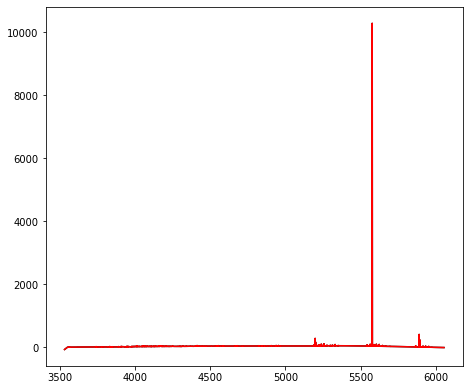

In [4]:
Sky=True
if Sky:
    exptime_sky='900'
    sky_nameA='LVM_skyA'
    sky_nameB='LVM_skyB'

    sky_fileA=sky_nameA+'_'+typ+'_full_'+exptime_sky+'_no_noise.fits'
    sky_fileB=sky_nameB+'_'+typ+'_full_'+exptime_sky+'_no_noise.fits'
    dir_cube='out_lvm_sim/'

    Total_SkyA,hdr2_skyA=fits.getdata(dir_cube+sky_fileA, 2, header=True)
    Wave_SkyA,hdr6_skyA=fits.getdata(dir_cube+sky_fileA, 6, header=True)
    hdu_skyA = fits.open(dir_cube+sky_fileA)
    table_hdu_skyA = hdu_skyA[7]
    table_data_skyA = table_hdu_skyA.data
    fibid_skyA=table_data_skyA.field('id')
    nx_sA,ny_sA=Total_SkyA.shape

    Total_SkyB,hdr2_skyB=fits.getdata(dir_cube+sky_fileB, 2, header=True)
    Wave_SkyB,hdr6_skyB=fits.getdata(dir_cube+sky_fileB, 6, header=True)
    hdu_skyB = fits.open(dir_cube+sky_fileB)
    table_hdu_skyB = hdu_skyB[7]
    table_data_skyB = table_hdu_skyB.data
    fibid_skyB=table_data_skyB.field('id')
    nx_sB,ny_sB=Total_SkyB.shape

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(6.8*1.1,5.5*1.2))
    plt.plot(Wave_SkyA,Total_SkyA[30,:],'-',color='black')
    plt.plot(Wave_SkyB,Total_SkyB[30,:],'-',color='red')
    plt.show()

    from scipy.interpolate.interpolate import interp1d
    import numpy as np

    fibid_F=np.zeros(nx+nx_sA+nx_sB,dtype=int)
    Total_F=np.zeros([nx+nx_sA+nx_sB,ny])
    Total_F[0:nx,:]=Total
    fibid_F[0:nx]=fibid
    for i in range(0, nx_sA):
        Temp=interp1d(Wave_SkyA,Total_SkyA[i,:],bounds_error=False,fill_value=0)(Wave)
        Total_F[i+nx,:]=Temp
        fibid_F[i+nx]=i+nx+1
    for i in range(0, nx_sB):
        Temp=interp1d(Wave_SkyB,Total_SkyB[i,:],bounds_error=False,fill_value=0)(Wave)
        Total_F[i+nx+nx_sA,:]=Temp
        fibid_F[i+nx+nx_sA]=i+nx+nx_sA+1
    nxf,nyf=Total_F.shape    

Define the flat exposures

In [5]:
Flat=False
from scipy.interpolate.interpolate import interp1d
import numpy as np
if Flat:
    Target0,hdr1=fits.getdata(dir_cube+cube_file.replace('_no_noise','_input').replace('_'+exptime,''), 1, header=True)

    Rst=Target[30,:]/Target0[30,:]
    Rst=Rst/np.nanmean(Rst)
    nt=np.where(np.isfinite(Rst))
    Wave1=np.copy(Wave)
    Rst1=np.copy(Rst)
    Wave1=Wave1[nt]
    Rst1=Rst1[nt]
    RstN=interp1d(Wave1,Rst1,bounds_error=False,fill_value=0)(Wave) 

    ke=1000
    krn=ke/(Wave[1]-Wave[0])
    from scipy import signal
    ker=signal.gaussian(500, krn )
    ker=ker/np.sum(ker)
    RstM=np.convolve(RstN,ker,mode="same")

    fig, ax = plt.subplots(figsize=(6.8*1.1,5.5*1.2))
    plt.plot(Wave1,Rst1,'-',color='green')
    plt.plot(Wave,Rst,'-',color='red')
    plt.plot(Wave,RstM,'-',color='blue')
    plt.show()

    RstM=RstM*5000


Define the Arc exposures

In [6]:
Arc=False
if Arc:
    arc_spec=twodlvm.ssp_extract_arc(Wave,dir_tem='libs/',col=typ)
    arc_spec=arc_spec*4
    fig, ax = plt.subplots(figsize=(6.8*1.1,5.5*1.2))
    #plt.plot(Wave1,Rst1,'-',color='green')
    plt.plot(Wave,arc_spec,'-',color='red')
    #plt.plot(Wave,RstM,'-',color='blue')
    plt.show()

Load the wavelength solution

In [7]:
from scipy.interpolate.interpolate import interp1d
import numpy as np
if typ == 'blue':
    expn='00002998'
    cam='b1'
if typ == 'red':
    expn='00001563'
    cam='r1'
if typ == 'ir':
    expn='00001563'
    cam='z1'
    
cube_file='drp_input/'+typ+'-channel-data/sdR-s-'+cam+'-'+expn+'.disp.fits'
blue_s,hdrB=fits.getdata(cube_file, 0, header=True)
wave_s=np.nanmean(blue_s,axis=0)
nyt=len(wave_s)
pixel=np.arange(0,len(wave_s))
Pix=interp1d(wave_s,pixel,bounds_error=False,fill_value=-10)(Wave)    

#fig, ax = plt.subplots(figsize=(6.8*1.1,5.5*1.2))
#plt.plot(Pix,arc_spec,'-',color='red')
#plt.show()

Run the 2D projection module

In [ ]:
mjd=str(int(hdr0["MJD"]))
expt=hdr0["EXPTIME"]
ra=hdr0["RA"]
dec=hdr0["DEC"]
name=hdr0["TARGET"]
nfib=648
ntt=150
expN=3

spectra=np.zeros([nyt-1000,nfib*3])
indx_t=np.arange(nfib*3,dtype=int)+1
import random
random.shuffle(indx_t)

nxt=nxf
flb='s'
n_cr=int(150*expt/900.0)
if Flat:
    nxt=nfib*3
    flb='f'
    n_cr=50
    Arc=False
if Arc:
    nxt=nfib*3
    flb='a'
    n_cr=30
    Flat=False
for j in range(800-ntt, nyt-200-ntt):
    for i in range(0, nxt):
        if Flat:
            if i == 0:
                nt=np.where((Pix >= j) & (Pix < j+1))[0]
                val=np.nansum(RstM[nt])
        elif Arc:
            if i == 0:
                nt=np.where((Pix >= j) & (Pix < j+1))[0]
                val=np.nansum(arc_spec[nt])
        else:
            nt=np.where((Pix >= j) & (Pix < j+1))[0]
            val=np.nansum(Total_F[i,nt])
        spectra[j-800+ntt,i]=val

#plt.xlim(990,1000)        
#plt.plot(np.nanmean(spectra,axis=1))        
id_t=np.zeros(nfib*3,dtype=int)
id_t[0:nxf]=np.copy(fibid_F)+1
for i in range(nxf,nfib*3):
    id_t[i]=i+1
#id_t=indx_t
twodlvm.run_2d(spectra,id_t,nfib=nfib,type=typ,cam=1,n_cr=n_cr,expN=expN,expt=expt,ra=ra,dec=dec,mjd=mjd,field_name=name,flb=flb,base_name='sdR')
twodlvm.run_2d(spectra,id_t,nfib=nfib,type=typ,cam=2,n_cr=n_cr,expN=expN,expt=expt,ra=ra,dec=dec,mjd=mjd,field_name=name,flb=flb,base_name='sdR')
twodlvm.run_2d(spectra,id_t,nfib=nfib,type=typ,cam=3,n_cr=n_cr,expN=expN,expt=expt,ra=ra,dec=dec,mjd=mjd,field_name=name,flb=flb,base_name='sdR')

1 b1
Using default PSF =1 pixel
1 b2
Using default PSF =1 pixel
